# Data Science NanoDegree

## Sparkify Capstone Project

Customer Churn, also known as Customer Attrition, is when the customer of a certain service stops using that service after a certain period of time. This proves troublesome for the service itself as it is of paramount importance to keep those customers for the sake of generating higher revenue.

Predicting customer churn is therefore an important task that many companies and service providers rely on to make sure their customers won't leave or stop using their service anytime soon. To meet this end, companies rely on a huge amount of data, usually known as Big Data, generated from the interactions of its users with its services, then analyze and model this data to be able to predict imminent churn for any given user.

In this Notebook, I will be using a dataset mimicking the interactions the users might have with popular music streaming services. The Sparkify dataset used here is a subset (128 MB) of the original (12 GB) dataset.

I will guide you through a machine learning solution created with Apache Spark's python API PySpark. I will explore, wrangle and model the dataset for the purpose of predicting users who will churn.

## Importing Libraries and Creating a Spark Session

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, FloatType
from pyspark.sql.functions import desc, asc, sum as Fsum, col, max as Fmax, when
from pyspark.ml.feature import Normalizer, PCA, StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from sklearn.metrics import f1_score, recall_score, precision_score

import sklearn.metrics as metrics

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset


In this section, I loaded the dataset using spark and cleaned the dataset from any potentially irrelevant data/users and removed any existing duplicate records

In [3]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
user_log.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Number of user interactions in the dataset

In [7]:
user_log.count()

286500

In [8]:
user_log.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [11]:
user_log.select('userId')\
  .dropDuplicates()\
  .count()

226

In [12]:
user_log.groupBy('userId') \
  .count()\
  .sort(desc("count"))\
  .show(10)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
+------+-----+
only showing top 10 rows



#### it appears we have an empty string that pops up in the user log data more than 8000 times
<br>
<br>
<br>


In [13]:
user_log.filter(user_log.userId=='') \
  .groupBy('page') \
  .count()\
  .sort(desc("count"))\
  .show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              Login| 3241|
|              About|  429|
|               Help|  272|
|           Register|   18|
|              Error|    6|
|Submit Registration|    5|
+-------------------+-----+



#### empty string user seems to be people who are not yet registered nor using the service
<br>
<br>
<br>


In [5]:
user_log = user_log.dropna(subset=['sessionId', 'userId'])

In [6]:
user_log = user_log.filter(user_log["userId"] != "")

#### Removed the empty userId from the dataset as it will not be helpful in churn classification and prediction
<br>
<br>
<br>


In [16]:
user_log.count()

278154

record count after removal

#### No missing userIds or SessionIds

<br>
<br>
<br>


In [7]:
user_log = user_log.dropDuplicates()

In [18]:
user_log.count()

278154

#### No duplicates were found

<br>
<br>
<br>


# Exploratory Data Analysis

In this section, I explore different aspects of the data and introduce the label column 'Churn' based on users who confirmed their cancellation of the service.


In [19]:
user_log.select("userId").dropDuplicates().count()

225

#### Total number of unique users is equal to 225

<br>
<br>
<br>


In [76]:
user_log.select('page').dropDuplicates().count()

19

In [77]:
user_log.groupBy('page') \
  .count()\
  .sort(desc("count"))\
  .show(22)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



#### Inserting a new churn column where each entry in that column will be set to 1 for a user whose cancellation has been confirmed and 0 otherwise

In [8]:
user_ids_churn = user_log.filter((user_log.page == 'Cancellation Confirmation')).collect()

In [9]:
user_ids_churn = [x.userId for x in user_ids_churn]

In [10]:
get_churn = udf(lambda x: 1 if x in user_ids_churn else 0 , IntegerType())

In [11]:
user_log = user_log.withColumn("Churn", get_churn(user_log.userId))

In [160]:
user_log.show(5)

+---------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|         artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|             song|status|           ts|           userAgent|userId|Churn|
+---------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|The Futureheads|Logged In|  Ainsley|     F|           80|  Farley|120.81587| free|McAllen-Edinburg-...|   PUT|   NextSong|1538304455000|      187|            Robot|   200|1538373133000|"Mozilla/5.0 (Win...|    78|    0|
|           null|Logged In|  Ainsley|     F|           81|  Farley|     null| free|McAllen-Edinburg-...|   PUT|Thumb

In [161]:
user_log.filter(user_log.page != 'Cancellation Confirmation').select('churn').take(1)

[Row(churn=0)]

In [162]:
user_log.filter(user_log.page == 'Cancellation Confirmation').select('churn').take(1)

[Row(churn=1)]

In [163]:
user_log.filter((user_log.userId == '18') ).select('churn', 'page').show()

+-----+---------------+
|churn|           page|
+-----+---------------+
|    1|      Thumbs Up|
|    1|Add to Playlist|
|    1|       NextSong|
|    1|Add to Playlist|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|     Add Friend|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|       NextSong|
|    1|     Add Friend|
|    1|       NextSong|
+-----+---------------+
only showing top 20 rows



Example of a user who churned

In [164]:
user_log.filter((user_log.userId == '30') ).select('churn', 'page').show()

+-----+-----------+
|churn|       page|
+-----+-----------+
|    0|  Downgrade|
|    0|   NextSong|
|    0|   NextSong|
|    0|     Logout|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|     Logout|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|Roll Advert|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
|    0|   NextSong|
+-----+-----------+
only showing top 20 rows



Example of a user who did not churn

In [165]:
userIds_no_churn = user_log.filter(user_log.Churn == 0)\
                   .select('userId')\
                   .dropDuplicates()\

In [166]:
userIds_no_churn_num = userIds_no_churn.count()

In [167]:
userIds_churn = user_log.filter(user_log.Churn == 1).select('userId').dropDuplicates()

In [168]:
userIds_churn_num = userIds_churn.count()

In [169]:
userIds_churn_num, userIds_no_churn_num

(52, 173)

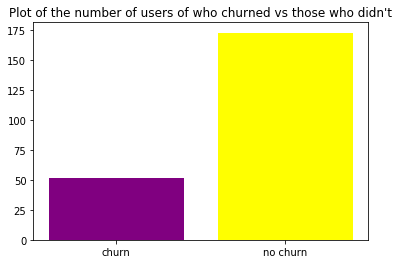

In [170]:
plt.bar([1, 2], [userIds_churn_num, userIds_no_churn_num]\
        , tick_label=['churn', 'no churn']\
        , align='center'\
        , color=['purple', 'yellow'])


plt.title("Plot of the number of users of who churned vs those who didn't")
plt.show()


### Case of imbalanced data set where more users did not churn that those who did

<br>
<br>
<br>


In [171]:
churn_songs_count = user_log.filter((user_log.Churn == 1) & (user_log.page == 'NextSong')).count()

In [172]:
no_churn_songs_count = user_log.filter((user_log.Churn == 0) & (user_log.page == 'NextSong')).count()

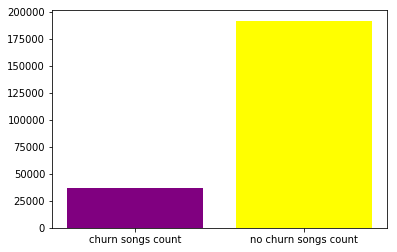

In [173]:
plt.bar([1, 2], [churn_songs_count, no_churn_songs_count],\
        tick_label=['churn songs count', 'no churn songs count'],\
        align='center',\
        color=['purple', 'yellow'])
plt.show()

### Amount of songs listened to by users who churned are much less that of users who didn't

<br>
<br>
<br>


In [38]:
churn_ad = user_log.filter((user_log.Churn == 1) & (user_log.page == 'Roll Advert')).count() / len(userIds_churn)

In [39]:
no_churn_ad = user_log.filter((user_log.Churn == 0) & (user_log.page == 'Roll Advert')).count() / len(userIds_no_churn)

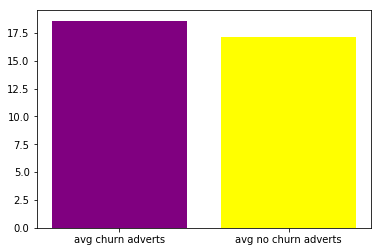

In [174]:
plt.bar([1, 2], [churn_ad, no_churn_ad],\
        tick_label=['avg churn adverts', 'avg no churn adverts'],\
        align='center',\
        color=['purple', 'yellow'])
plt.show()

### Users who churned get around 19 ads on average, two more than those who didn't

<br>
<br>
<br>


In [41]:
churn_F = user_log.filter((user_log.Churn == 1) & (user_log.gender == 'F')).select('userId').dropDuplicates().count()

In [42]:
churn_M = user_log.filter((user_log.Churn == 1) & (user_log.gender == 'M')).select('userId').dropDuplicates().count()

In [43]:
no_churn_F = user_log.filter((user_log.Churn == 0) & (user_log.gender == 'F')).select('userId').dropDuplicates().count()

In [44]:
no_churn_M = user_log.filter((user_log.Churn == 0) & (user_log.gender == 'M')).select('userId').dropDuplicates().count()

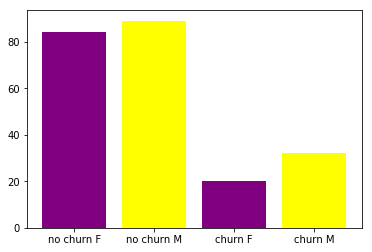

In [175]:
plt.bar([1, 2, 3, 4], [no_churn_F,no_churn_M, churn_F, churn_M],\
        tick_label=['no churn F', 'no churn M', 'churn F', 'churn M'],\
        align='center',\
        color=['purple', 'yellow'])
plt.show()

In [180]:
print('M-F ratio for users who churned: {}'.format(churn_M/churn_F))

M-F ratio for users who churned: 1.6


In [181]:
print('M-F ratio for users who did not churn: {}'.format(no_churn_M/no_churn_F))

M-F ratio for users who did not churn: 1.0595238095238095


### Slightly higher ratio of Males to Females for user who churned to that of users who didn't

<br>
<br>
<br>


In [46]:
sum_churn_thumbsup = user_log.filter((user_log.Churn == 1) & (user_log.page == 'Thumbs Up'))\
                    .groupBy('userId')\
                    .count()\
                    .select('count')\
                    .agg(Fsum('count'))\
                    .collect()

avg_churn_thumbsup = sum_churn_thumbsup[0]['sum(count)'] / userIds_churn_num
print(avg_churn_thumbsup)

35.75


In [47]:
sum_no_churn_thumbsup = user_log.filter((user_log.Churn == 0) & (user_log.page == 'Thumbs Up'))\
                    .groupBy('userId')\
                    .count()\
                    .select('count')\
                    .agg(Fsum('count'))\
                    .collect()

avg_no_churn_thumbsup = sum_no_churn_thumbsup[0]['sum(count)'] / userIds_no_churn_num
print(avg_no_churn_thumbsup)

61.80346820809248


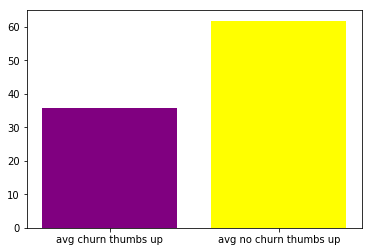

In [177]:
plt.bar([1, 2], [avg_churn_thumbsup,avg_no_churn_thumbsup], \
        tick_label=['avg churn thumbs up', 'avg no churn thumbs up'], \
        align='center' , \
        color=['purple', 'yellow'])
plt.show()

### users who did not churn gave almost twice the number of thumbs up as those who did on average
<br>
<br>
<br>


# Feature Engineering


In this section, I create different features to be used for modeling after exploring and understanding the data and the differentiating behaviours and patterns of both users who churn and users who don't

In [49]:
user_log.head()

Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78', Churn=0)

### Song Count feature

Adding the number of songs each user has listened to throughout the dataset

In [12]:
song_count = user_log.filter(user_log.song != '').groupBy(col('userId')).count().withColumnRenamed("count", "Songs")

In [51]:
song_count.count()

225

In [52]:
song_count.head(5)

[Row(userId='100010', Songs=275),
 Row(userId='200002', Songs=387),
 Row(userId='125', Songs=8),
 Row(userId='51', Songs=2111),
 Row(userId='124', Songs=4079)]

### Thumbs Up Count feature

Adding the number of Thumbs Up each user has given

In [13]:
# Thumbs Up
user_log = user_log.withColumn('ThumbsUp', (when(col('page')== 'Thumbs Up',1)\
                                                            .otherwise(0)))
thumbsup_count = user_log.groupby('userId')\
                       .agg(Fsum('ThumbsUp')\
                       .alias('countThumbsUp'))

In [54]:
thumbsup_count.head(5)

[Row(userId='100010', countThumbsUp=17),
 Row(userId='200002', countThumbsUp=21),
 Row(userId='125', countThumbsUp=0),
 Row(userId='51', countThumbsUp=100),
 Row(userId='124', countThumbsUp=171)]

In [55]:
thumbsup_count.count()

225

In [14]:
# joining the song count and thumbs up feature 
df_song_thumbs_up = song_count.join(thumbsup_count, on=['userId'])

In [57]:
df_song_thumbs_up.count()

225

In [58]:
df_song_thumbs_up.head(5)

[Row(userId='100010', Songs=275, countThumbsUp=17),
 Row(userId='200002', Songs=387, countThumbsUp=21),
 Row(userId='125', Songs=8, countThumbsUp=0),
 Row(userId='51', Songs=2111, countThumbsUp=100),
 Row(userId='124', Songs=4079, countThumbsUp=171)]

### Thumbs Down Count feature

Adding the number of Thumbs Down each user has given

In [15]:
# Thumbs Down
user_log = user_log.withColumn('ThumbsDown', (when(col('page')== 'Thumbs Down',1)\
                                                            .otherwise(0)))
thumbsdown_count = user_log.groupby('userId')\
                       .agg(Fsum('ThumbsDown')\
                       .alias('countThumbsDown'))

In [16]:
# joining the previous features and thumbs Down feature 
df_song_thumbs_up_down = df_song_thumbs_up.join(thumbsdown_count, on=['userId'])

In [61]:
df_song_thumbs_up_down.count()

225

### Total Thumbs Count feature

Adding the Total number of Thumbs Up / Thumbs Down for each user. One way of measuring the amount of interaction each user had

In [17]:
count_total_thumbs = udf(lambda x, y: x+y , IntegerType())

In [18]:
df_song_thumbs_up_down_tot = df_song_thumbs_up_down.withColumn('countTotalThumbs',\
                                                           count_total_thumbs(df_song_thumbs_up_down['countThumbsUp']\
                                                                              ,df_song_thumbs_up_down['countThumbsDown']))

In [64]:
df_song_thumbs_up_down_tot.show(2)

+------+-----+-------------+---------------+----------------+
|userId|Songs|countThumbsUp|countThumbsDown|countTotalThumbs|
+------+-----+-------------+---------------+----------------+
|100010|  275|           17|              5|              22|
|200002|  387|           21|              6|              27|
+------+-----+-------------+---------------+----------------+
only showing top 2 rows



### Number of Friends feature

Adding the number of friends each user has

In [19]:
num_friends_df = user_log\
                   .filter(user_log.page=="Add Friend")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countFriends")

In [20]:
# joining the previous features and the number of friends feature 
df_song_thumbs_up_down_tot_fr = df_song_thumbs_up_down_tot.join(num_friends_df, 'userId', how='left').fillna(0)

### Number of Logins feature

Adding the number of times each user logged in to the service

In [21]:
num_logins_df = user_log\
                   .select('userId','sessionId')\
                   .dropDuplicates()\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countLogins")

In [22]:
# joining the previous features and Number of logins feature 
df_song_thumbs_up_down_tot_fr_log = df_song_thumbs_up_down_tot_fr.join(num_logins_df, 'userId')

In [69]:
df_song_thumbs_up_down_tot_fr_log.count()

225

### Number of errors feature

Adding the number of errors each user encountered while using the service

In [23]:
num_errors_df = user_log\
                   .filter(user_log.page=="Error")\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed("count","countErrors")

In [24]:
# joining the previous features and Number of errors feature 
df_song_thumbs_up_down_tot_fr_log_err = df_song_thumbs_up_down_tot_fr_log.join(num_errors_df, 'userId', how='left').fillna(0)

### Churn column

Adding the churn column for each user to be used as the label column

In [25]:
user_churn = user_log.groupBy(col('userId')).agg(Fmax(col('Churn'))).withColumnRenamed("max(Churn)", "Churn")

In [26]:
df_song_thumbs_up_down_tot_fr_log_err_ch = df_song_thumbs_up_down_tot_fr_log_err.join(user_churn, on=['userId'])

In [74]:
df_song_thumbs_up_down_tot_fr_log_err_ch.show(2)

+------+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+
|userId|Songs|countThumbsUp|countThumbsDown|countTotalThumbs|countFriends|countLogins|countErrors|Churn|
+------+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+
|100010|  275|           17|              5|              22|           4|          7|          0|    0|
|200002|  387|           21|              6|              27|           4|          6|          0|    0|
+------+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+
only showing top 2 rows



In [75]:
df_song_thumbs_up_down_tot_fr_log_err_ch

DataFrame[userId: string, Songs: bigint, countThumbsUp: bigint, countThumbsDown: bigint, countTotalThumbs: int, countFriends: bigint, countLogins: bigint, countErrors: bigint, Churn: int]

# Modeling

In this section, I prepare the dataset created by converting it into the suitable vector format for training and scaling the data. I then compare the usage of different classification models on the training set and measure their results on the testing set

In [27]:
# drop userId column as it will not help in the modeling process
df_final = df_song_thumbs_up_down_tot_fr_log_err_ch.drop("userId")

In [186]:
df_final.columns[:-1]

['Songs',
 'countThumbsUp',
 'countThumbsDown',
 'countTotalThumbs',
 'countFriends',
 'countLogins',
 'countErrors']

In [28]:
# Combine the features into a feature vector to be used by the machine learning models
assembler2 = VectorAssembler(inputCols=df_final.columns[:-1], outputCol="featVec")
df_final_vec = assembler2.transform(df_final)

In [188]:
df_final_vec.show()

+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+
|Songs|countThumbsUp|countThumbsDown|countTotalThumbs|countFriends|countLogins|countErrors|Churn|             featVec|
+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+
|  275|           17|              5|              22|           4|          7|          0|    0|[275.0,17.0,5.0,2...|
|  387|           21|              6|              27|           4|          6|          0|    0|[387.0,21.0,6.0,2...|
|    8|            0|              0|               0|           0|          1|          0|    1| (7,[0,5],[8.0,1.0])|
| 2111|          100|             21|             121|          28|         10|          1|    1|[2111.0,100.0,21....|
| 4079|          171|             41|             212|          74|         29|          6|    0|[4079.0,171.0,41....|
|  150|            7|              1|           

In [29]:
# Scaling the feature vector using min-max scaling
scaler = MinMaxScaler(inputCol="featVec", outputCol="featVecMinMaxScaled")
scalerModel = scaler.fit(df_final_vec)
df_final_vec_scaled = scalerModel.transform(df_final_vec)

In [190]:
df_final_vec_scaled.show()

+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+--------------------+
|Songs|countThumbsUp|countThumbsDown|countTotalThumbs|countFriends|countLogins|countErrors|Churn|             featVec| featVecMinMaxScaled|
+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+--------------------+
|  275|           17|              5|              22|           4|          7|          0|    0|[275.0,17.0,5.0,2...|[0.03400425053131...|
|  387|           21|              6|              27|           4|          6|          0|    0|[387.0,21.0,6.0,2...|[0.04800600075009...|
|    8|            0|              0|               0|           0|          1|          0|    1| (7,[0,5],[8.0,1.0])|[6.25078134766845...|
| 2111|          100|             21|             121|          28|         10|          1|    1|[2111.0,100.0,21....|[0.26353294161770...|
| 4079|          171

In [191]:
df_final_vec_scaled.columns

['Songs',
 'countThumbsUp',
 'countThumbsDown',
 'countTotalThumbs',
 'countFriends',
 'countLogins',
 'countErrors',
 'Churn',
 'featVec',
 'featVecMinMaxScaled']

In [32]:
df_final_vec_scaled = df_final_vec_scaled.withColumnRenamed('Churn', 'label')
df_final_vec_scaled = df_final_vec_scaled.withColumnRenamed('featVecMinMaxScaled', 'features')

In [33]:
df_final_vec_scaled.show(1)

+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+--------------------+
|Songs|countThumbsUp|countThumbsDown|countTotalThumbs|countFriends|countLogins|countErrors|label|             featVec|            features|
+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+--------------------+
|  275|           17|              5|              22|           4|          7|          0|    0|[275.0,17.0,5.0,2...|[0.03400425053131...|
+-----+-------------+---------------+----------------+------------+-----------+-----------+-----+--------------------+--------------------+
only showing top 1 row



In [34]:
# Splitting the data into 70-30 for training-Validation and testing
Training, Testing =  df_final_vec_scaled.randomSplit([0.7,0.3], seed=42)

#### Given that the dataset is imbalanced, using the accuracy metric is not the correct way to measure the performance of the models. Instead, the focus will be on Precision, Recall, F-Measure and the Area under the Precision-Recall Curve

In [35]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')

In [36]:
# Calculate a balancing ratio to account for the class imbalance
balancing_ratio = Training.filter(Training.label==0).count()/Training.count()
Training=Training.withColumn("classWeights", when(Training.label == 1,balancing_ratio).otherwise(1-balancing_ratio))


Added an extra 'classWeights' column to be used by the logistic regression model to account for the data imbalance

In [201]:
Training.show(5)

+-----+--------------------+-------------------+
|label|            features|       classWeights|
+-----+--------------------+-------------------+
|    0|[0.03400425053131...|0.22699386503067487|
|    1|[6.25078134766845...| 0.7730061349693251|
|    0|[0.01837729716214...|0.22699386503067487|
|    1|[0.26353294161770...| 0.7730061349693251|
|    1|[0.35479434929366...| 0.7730061349693251|
+-----+--------------------+-------------------+
only showing top 5 rows



In [37]:
# Calculate and print f1, recall and precision scores
def cal_metrics(predictions_pandas):
    f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction)
    recall = recall_score(predictions_pandas.label, predictions_pandas.prediction)
    precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)
    return recall, precision, f1

### Logistic Regression

In [38]:
lr = LogisticRegression(maxIter=10^5, weightCol='classWeights')

In [39]:
lrModel = lr.fit(Training)

In [40]:
trainingSummary = lrModel.summary

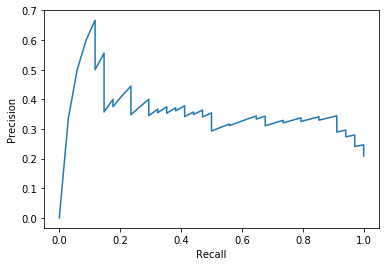

In [41]:
# Plot the recall-precision curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

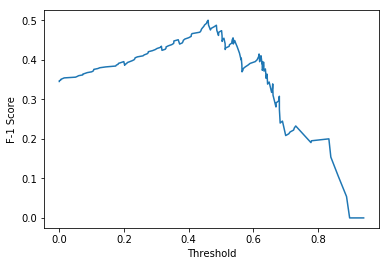

In [42]:
# Plot the threshold-F-Measure curve
fm = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(fm['threshold'], fm['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-1 Score')
plt.show()

In [43]:
predictions_lr = lrModel.transform(Testing)
predictions_pandas_lr = predictions_lr.toPandas()

recall, precision, f1 = cal_metrics(predictions_pandas_lr)

print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision))

F1-Score: 0.48275862068965514, Recall: 0.7777777777777778, Precision: 0.35


In [44]:
print('Test Area Under PR: ', evaluator.evaluate(predictions_lr))

Test Area Under PR:  0.36998087532188956


In [ ]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10, 10^5])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(Training)
predictions = cvModel.transform(Testing)
predictions_pandas = predictions.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(predictions))

In [211]:
recall, precision, f1 = cal_metrics(predictions_pandas)

print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision))

F1-Score: 0.4090909090909091, Recall: 0.6, Precision: 0.3103448275862069


### Decision Tree

In [36]:
Dt = DecisionTreeClassifier()

In [37]:
paramGrid_Dt = ParamGridBuilder()\
            .addGrid(Dt.maxDepth, [5, 10])\
            .addGrid(Dt.maxBins , [32,64])\
            .build()

crossval_Dt = CrossValidator(estimator=Dt,
                         estimatorParamMaps= paramGrid_Dt,
                         evaluator = evaluator,
                         numFolds = 3)

cvModel_Dt = crossval_Dt.fit(Training)


Dt_test_preds = cvModel_Dt.transform(Testing)
predictions_pandas_Dt = Dt_test_preds.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(Dt_test_preds))

Test Area Under PR:  0.2922686063672781


In [43]:
recall_Dt, precision_Dt, f1_Dt = cal_metrics(predictions_pandas_Dt)
print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1_Dt, recall_Dt, precision_Dt))

F1-Score: 0.23529411764705882, Recall: 0.26666666666666666, Precision: 0.21052631578947367


### Random Forest

In [44]:
Rf = RandomForestClassifier()

In [45]:
paramGrid_Rf = ParamGridBuilder()\
            .addGrid(Rf.numTrees, [10,50,100])\
            .build()

crossval_Rf =  CrossValidator(estimator=Rf,
                         estimatorParamMaps = paramGrid_Rf,
                         evaluator = evaluator,
                         numFolds = 3)

cvModel_Rf = crossval_Rf.fit(Training)

Rf_test_preds = cvModel_Rf.transform(Testing)

predictions_pandas_Rf = Rf_test_preds.toPandas()
print('Test Area Under PR: ', evaluator.evaluate(Rf_test_preds))

Test Area Under PR:  0.36365059349693685


In [46]:
recall, precision, f1 = cal_metrics(predictions_pandas_Rf)
print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision))

F1-Score: 0.3, Recall: 0.2, Precision: 0.6


# Conclusion

From the results shown, it can be seen that Logistic regression gave the best results and therefore should be used moving on.
<br>

The results however, can still be improved in many ways:
- Creating new features that take time into consideration
- Trying out different models such as Gradient Boost Tree Classifier
- Trying out different tuning parameters
- Some of the features generated here should be adjusted to take into account that some users' logs were recorded much later, towards the end of the dataset, than other users. 
- Dealing with the outliers present in the dataset if any